# 1. MRI memory-time-accuracy analysis

In [1]:
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import os, sys
import argparse
import time
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import time

# MELD toolbox
import meld.recon as recon
from meld.recon import UnrolledNetwork

# import local experiment files
sys.path.append('../')
import dataloader
# import visualizer
import model

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [4]:
# Setup device
device_no = 1
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

In [5]:
datapath = '/mikQNAP/dataset_train_full.h5' 
dataset = dataloader.dataloader(datapath, 
                                noise_std = 3e-2)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
for i_batch, sample_batched in enumerate(data_loader):
    imgs_0, maps_0, meas_0, mask_0 = sample_batched
    break

In [6]:
def setup_run(num_unrolls, meldFlag=False, cpList=None):
    metadata['num_unrolls'] = num_unrolls
    network = model.model(metadata, device=device)
#     imgs_0, maps_0, meas_0, mask_0 = data_loader[0]
    adj_0 = network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
    trainable_network = UnrolledNetwork(network.network, 
                                        torch.zeros_like(adj_0), 
                                        memlimit=1e9, 
                                        setupFlag = False,
                                        device=device)
    trainable_network.meldFlag = meldFlag
    if cpList is not None:
        trainable_network.cpList = cpList
    else:
        trainable_network.cpList = [-1]
        
    if trainable_network.meldFlag is False:
        trainable_network.cpList = [-1]
    return network, trainable_network
    
metadata = {'num_unrolls': 4, 'lamb': 1.0, 'alpha': 1e-2}

## Evaluate Time and Memory for standard backpropagation

In [7]:
Nunrolls = 5
unrollList = np.linspace(10,30, Nunrolls,dtype='int32')
print(unrollList)

# setup time and memory
timings1 = np.zeros(Nunrolls)
memory1 = np.zeros(Nunrolls)



# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    network, trainable_network = setup_run(unrollList[nn])
    
    # setup data
#     imgs_0, maps_0, meas_0, mask_0 = data_loader[0]
    adj_0 = network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
    
    # evaluate time
    start_time = time.time()
    torch.cuda.empty_cache()
    start_memory = torch.cuda.memory_cached(device)
    xN_tmp, loss_tmp, _, _ = trainable_network.forward(torch.zeros_like(adj_0), imgs_0.to(device))
    end_time = time.time()
    end_memory = torch.cuda.memory_cached(device)
    
    timings1[nn] = end_time - start_time
    memory1[nn] = end_memory - start_memory


[10 15 20 25 30]
Number of unrolls: 10
True
Number of unrolls: 15
True
Number of unrolls: 20
True
Number of unrolls: 25
True
Number of unrolls: 30
True


In [11]:
print(timings1)
print(memory1 / 1024**2)

[0.24144197 0.47312093 0.61608505 0.73396325 0.9093039 ]
[1960. 2928. 3882. 4852. 5820.]


## Evaluate Time | Memory | Accuracy for reverse recalculation

In [12]:
# setup time and memory
timings2 = np.zeros(Nunrolls)
memory2 = np.zeros(Nunrolls)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = [-1])
    
    # setup data
#     input_data, output_data = dataset[0]
    adj_0 = network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
    
    # evaluate time
    start_time = time.time()
    torch.cuda.empty_cache()
    start_memory = torch.cuda.memory_cached(device)
    xN_tmp, loss_tmp, _, _ = trainable_network.forward(torch.zeros_like(adj_0), imgs_0.to(device))
    end_time = time.time()
    end_memory = torch.cuda.memory_cached(device)
    
    timings2[nn] = end_time - start_time
    memory2[nn] = end_memory - start_memory

    
# setup accuracy
accuracy2 = np.zeros(Nunrolls)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = [-1])
    
    # setup data
#     input_data, output_data = dataset[0]
    adj_0 = network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
    
    # evaluate time
    xN_tmp, loss_tmp, Xf, Xb = trainable_network.forward(torch.zeros_like(adj_0), imgs_0.to(device), interFlag=True)

    error = Xf - Xb
    accuracy2[nn] = np.mean(error.cpu().numpy())**2


Number of unrolls: 10
True
Number of unrolls: 15
True
Number of unrolls: 20
True
Number of unrolls: 25
True
Number of unrolls: 30
True
Number of unrolls: 10
True
Number of unrolls: 15
True
Number of unrolls: 20
True
Number of unrolls: 25
True
Number of unrolls: 30
True


In [13]:
print(timings2)
print(memory2 / 1024**2)
print(accuracy2)

[0.51015067 0.75874734 0.9755137  1.22592044 1.35264778]
[218. 216. 218. 216. 214.]
[2.12725069e-09 8.65498996e-09 4.07594304e-04 2.08791545e-01
 9.07063020e+02]


## Evaluate MELD linear checkpointing

In [14]:
timings3 = np.zeros(Nunrolls)
memory3 = np.zeros(Nunrolls)

# setup checkpoints
Ncp = 10
ckpts = [[it for it in range(0,N,Ncp)] for N in unrollList]
print(ckpts)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    print(ckpts[nn])
    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = ckpts[nn])
    
    # setup data
#     input_data, output_data = dataset[0]
    adj_0 = network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
    
    # evaluate time
    start_time = time.time()
    torch.cuda.empty_cache()
    start_memory = torch.cuda.memory_cached(device)
    xN_tmp, loss_tmp, _, _ = trainable_network.forward(torch.zeros_like(adj_0), imgs_0.to(device))
    end_time = time.time()
    end_memory = torch.cuda.memory_cached(device)
    
    timings3[nn] = end_time - start_time
    memory3[nn] = end_memory - start_memory

    
# setup accuracy
accuracy3 = np.zeros(Nunrolls)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    print(ckpts[nn])

    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = ckpts[nn])
    
    # setup data
#     input_data, output_data = dataset[0]
    adj_0 = network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
    
    # evaluate time
    xN_tmp, loss_tmp, Xf, Xb = trainable_network.forward(torch.zeros_like(adj_0), imgs_0.to(device), interFlag=True)

    error = Xf - Xb
    accuracy3[nn] = np.mean(error.cpu().numpy())**2


[[0], [0, 10], [0, 10], [0, 10, 20], [0, 10, 20]]
Number of unrolls: 10
[0]
True
Number of unrolls: 15
[0, 10]
True
Number of unrolls: 20
[0, 10]
True
Number of unrolls: 25
[0, 10, 20]
True
Number of unrolls: 30
[0, 10, 20]
True
Number of unrolls: 10
[0]
True
Number of unrolls: 15
[0, 10]
True
Number of unrolls: 20
[0, 10]
True
Number of unrolls: 25
[0, 10, 20]
True
Number of unrolls: 30
[0, 10, 20]
True


In [15]:
print(timings3)
print(memory3 / 1024**2)
print(accuracy3)

[0.48698831 0.70837903 0.96097898 1.16146994 1.40314031]
[216. 216. 214. 216. 216.]
[4.94631007e-10 1.92571140e-11 1.13482720e-10 1.40464497e-10
 5.84255903e-10]


## Evaluate MELD exponential checkpointing

In [11]:
timings4 = np.zeros(Nunrolls)
memory4 = np.zeros(Nunrolls)

# setup checkpoints
Ncp = 15
tau = 25
ckpts = [[int(N*(1-np.exp(-t/tau))) for t in range(0,N,Ncp)] for N in unrollList]
print(ckpts)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    print(ckpts[nn])
    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = ckpts[nn])
    
    # setup data
    input_data, output_data = dataset[0]
    x0 = network.initialize(input_data.to(device), device=device)
    
    # evaluate time
    start_time = time.time()
    torch.cuda.empty_cache()
    start_memory = torch.cuda.memory_cached(device)
    xN_tmp, loss_tmp, _, _ = trainable_network.forward(x0, output_data.to(device))
    end_time = time.time()
    end_memory = torch.cuda.memory_cached(device)
    
    timings4[nn] = end_time - start_time
    memory4[nn] = end_memory - start_memory

    
# setup accuracy
accuracy4 = np.zeros(Nunrolls)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    print(ckpts[nn])

    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = ckpts[nn])
    
    # setup data
    input_data, output_data = dataset[0]
    x0 = network.initialize(input_data.to(device), device=device)
    
    # evaluate time
    xN_tmp, loss_tmp, Xf, Xb = trainable_network.forward(x0, output_data.to(device), interFlag=True)

    error = Xf - Xb
    accuracy4[nn] = np.mean(error.cpu().numpy())**2


[[0], [0, 14, 22], [0, 24, 38, 45], [0, 34, 53, 64, 70, 73], [0, 45, 69, 83, 90, 95, 97]]
Number of unrolls: 10
[0]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 32
[0, 14, 22]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 55
[0, 24, 38, 45]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 77
[0, 34, 53, 64, 70, 73]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 100
[0, 45, 69, 83, 90, 95, 97]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 10
[0]
Reconstruction's pixel size (

In [12]:
print(timings4)
print(memory4 / 1024**2)
print(accuracy4)

[ 1.13468456  3.29435182  5.72816396  8.48133898 10.79009628]
[76. 78. 78. 80. 80.]
[1.01208459e-09 2.89461563e-10 4.36555057e-10 1.41074453e-09
 1.77746675e-05]


<IPython.core.display.Javascript object>


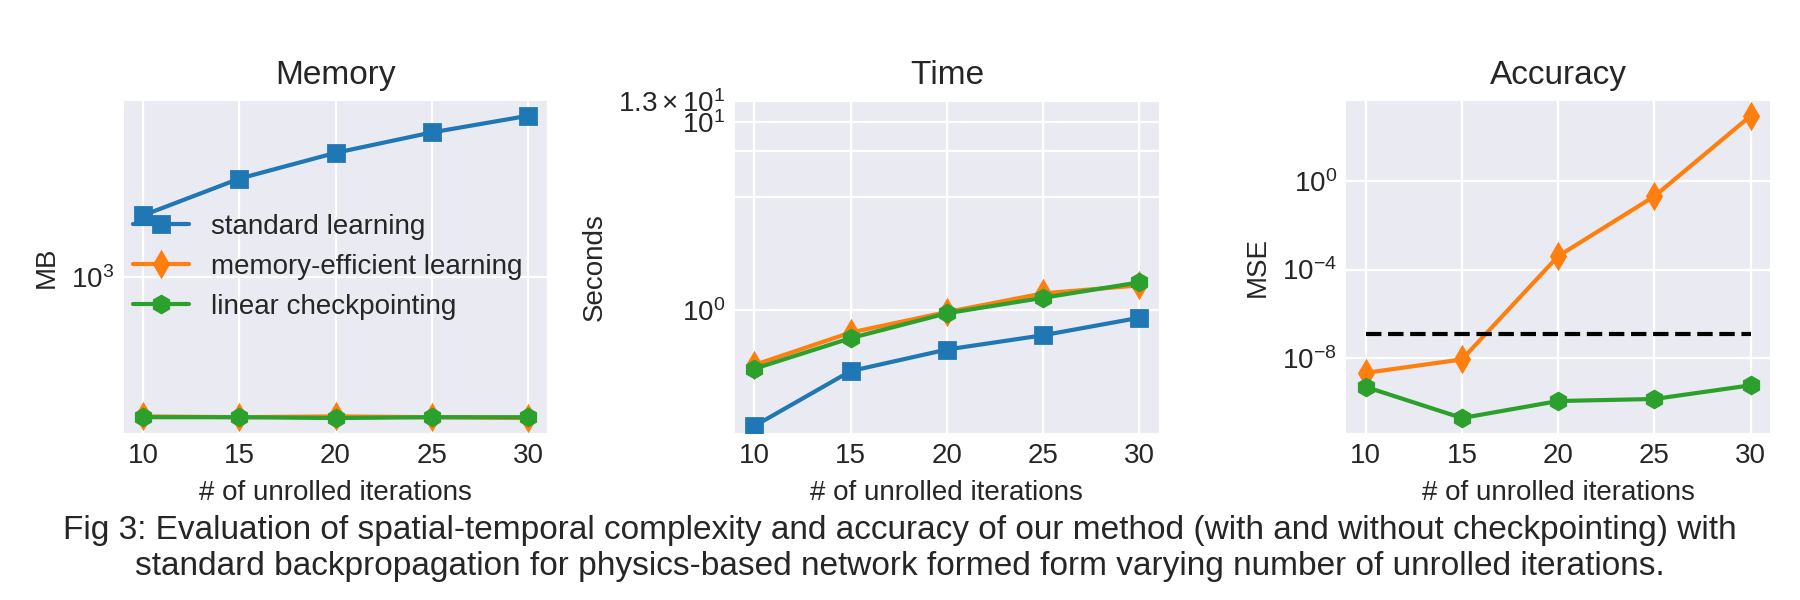

In [32]:
plt.figure(figsize=(9,3))
plt.subplot(131)
factor = 1024**2
plt.semilogy(unrollList,memory1/factor,'C0s-',label='standard learning')
plt.semilogy(unrollList,memory2/factor,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,memory3/factor,'C2h-',label='linear checkpointing')
# plt.semilogy(unrollList,memory4/factor,'C3h-',label='exponential checkpointing')
plt.title('Memory')
plt.xlabel('# of unrolled iterations')
plt.ylabel('MB')
# plt.yticks(np.arange(100, 2000, 400))
# plt.axis([0, 110, 50, 7500])
# plt.yticks(np.arange(50, 7500, 1000))
plt.grid('on')
plt.legend()


plt.subplot(132)
plt.semilogy(unrollList,timings1,'C0s-',label='standard learning')
plt.semilogy(unrollList,timings2,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,timings3,'C2h-',label='linear checkpointing')
# plt.semilogy(unrollList,timings4,'C3h-',label='exponential checkpointing')
# plt.axis([0, 110, 0, 15])
plt.yticks(np.arange(1, 15, 3))
plt.grid('on')

plt.title('Time')
plt.xlabel('# of unrolled iterations')
plt.ylabel('Seconds')

plt.subplot(133)
plt.semilogy(unrollList,accuracy2,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,accuracy3,'C2h-',label='linear checkpointing')
# plt.semilogy(unrollList,accuracy4,'C3h-',label='exponential checkpointing')

eps = np.finfo(np.float32).eps * np.ones(len(unrollList))
plt.semilogy(unrollList,eps,'k--',label='Mach. Eps.')

plt.grid('on')

plt.title('Accuracy')
plt.xlabel('# of unrolled iterations')
plt.ylabel('MSE')


plt.figtext(0.5, 0.05, "Fig 3: Evaluation of spatial-temporal complexity and accuracy of our method (with and without checkpointing) with standard backpropagation for physics-based network formed form varying number of unrolled iterations.", wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.savefig('./memory-time-accuracy-mri-1.png',dpi=300)



<IPython.core.display.Javascript object>


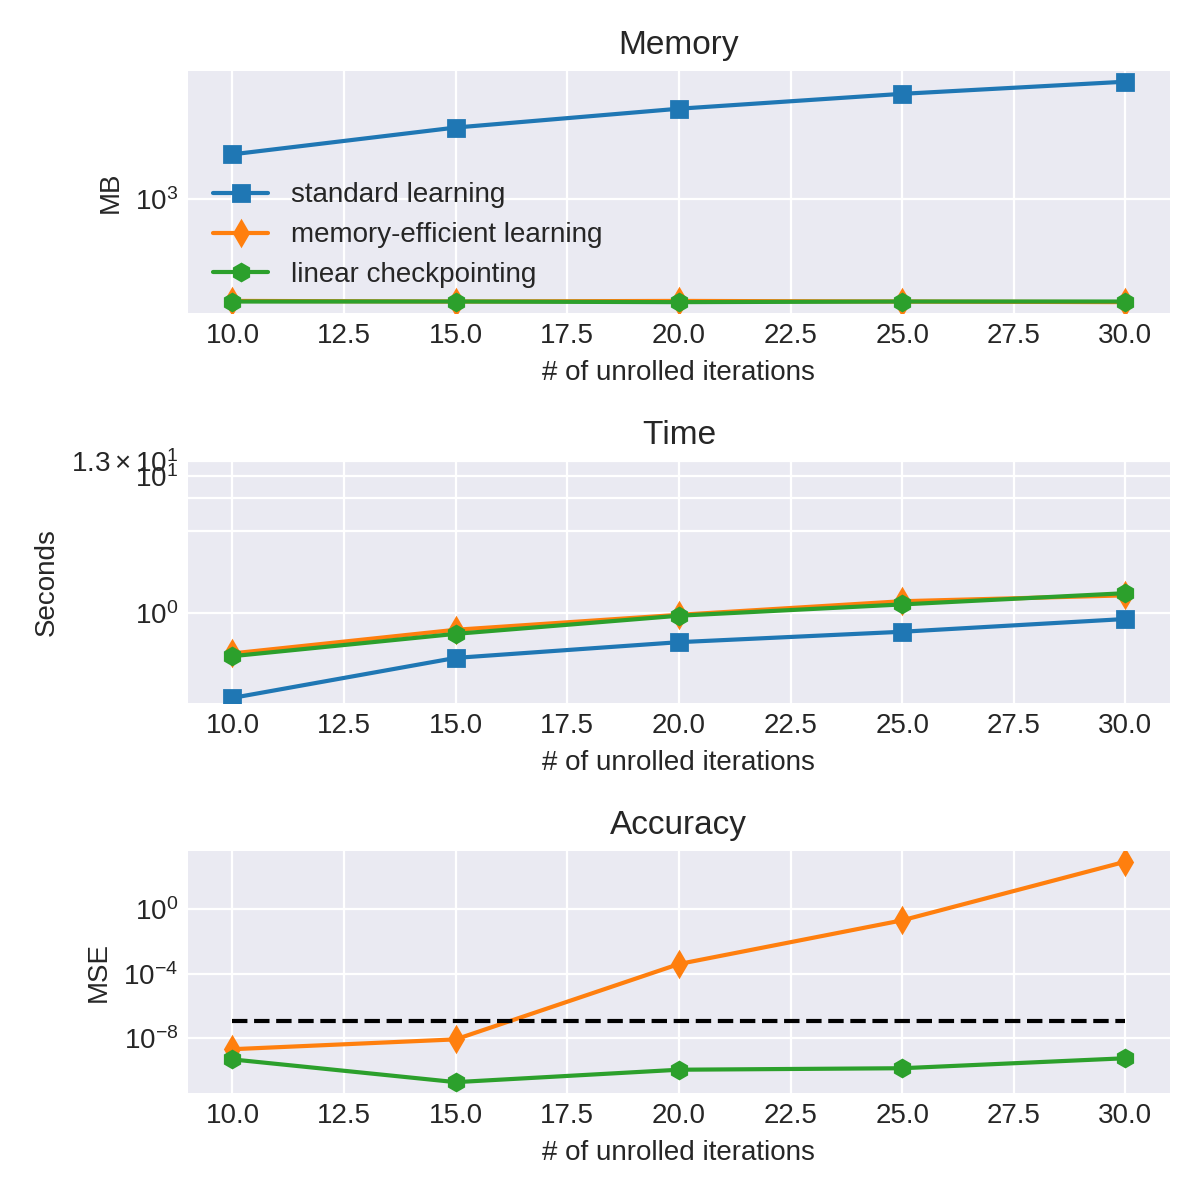

In [17]:
plt.figure(figsize=(6,6))
plt.subplot(311)
factor = 1024**2
plt.semilogy(unrollList,memory1/factor,'C0s-',label='standard learning')
plt.semilogy(unrollList,memory2/factor,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,memory3/factor,'C2h-',label='linear checkpointing')
# plt.semilogy(unrollList,memory4/factor,'C3h-',label='exponential checkpointing')
plt.title('Memory')
plt.xlabel('# of unrolled iterations')
plt.ylabel('MB')
# plt.yticks(np.arange(100, 2000, 400))\
# plt.axis([0, 110, 50, 7500])
# plt.yticks(np.arange(50, 7500, 1000))
plt.grid('on')
plt.legend()


plt.subplot(312)
plt.semilogy(unrollList,timings1,'C0s-',label='standard learning')
plt.semilogy(unrollList,timings2,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,timings3,'C2h-',label='linear checkpointing')
# plt.semilogy(unrollList,timings4,'C3h-',label='exponential checkpointing')
# plt.axis([0, 110, 0, 15])
plt.yticks(np.arange(1, 15, 3))
plt.grid('on')

plt.title('Time')
plt.xlabel('# of unrolled iterations')
plt.ylabel('Seconds')

plt.subplot(313)
plt.semilogy(unrollList,accuracy2,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,accuracy3,'C2h-',label='linear checkpointing')
# plt.semilogy(unrollList,accuracy4,'C3h-',label='exponential checkpointing')

eps = np.finfo(np.float32).eps * np.ones(len(unrollList))
plt.semilogy(unrollList,eps,'k--',label='Mach. Eps.')

plt.grid('on')

plt.title('Accuracy')
plt.xlabel('# of unrolled iterations')
plt.ylabel('MSE')

plt.tight_layout()
plt.savefig('./memory-time-accuracy-mri-2.png',dpi=300)
